# Import Required Libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import json

# Get Data from GraphQL

In [41]:
accessToken='QmURZTQbn9R9nvuCCgAPJ6zcDayaRuMpWmxeyYEVxc5bxR'   # from the website
endpoint='https://api.thegraph.com/subgraphs/name/muranox/uniswap-v3-matic' # from given website

# 1. Use GraphQL to download pool data for Uniswap v3 for MATIC(or wrapped MATIC) & USDC token pair.

In [38]:
Query="""query {
    pools{
        id
        createdAtTimestamp
        liquidity
        volumeUSD
        volumeToken0
        volumeToken1
        feesUSD
        feeTier
        }
}"""
r = requests.post(endpoint, json={"query": Query})
print(json.dumps(r.json(), indent=2))

{
  "data": {
    "pools": [
      {
        "id": "0x001743596c8c1d9db739f361b4879909dd4e320c",
        "createdAtTimestamp": "1641120448",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0",
        "volumeToken1": "0",
        "feesUSD": "0",
        "feeTier": "10000"
      },
      {
        "id": "0x0048c7a3cd5cd28b1a2fcc1277bb3146ac33e3ff",
        "createdAtTimestamp": "1643118382",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0",
        "volumeToken1": "0",
        "feesUSD": "0",
        "feeTier": "10000"
      },
      {
        "id": "0x00b15004f026994582c07777ca837c535b2fcd88",
        "createdAtTimestamp": "1640209905",
        "liquidity": "0",
        "volumeUSD": "0",
        "volumeToken0": "0.076588481410774537",
        "volumeToken1": "23247.418369187447350224",
        "feesUSD": "0",
        "feeTier": "3000"
      },
      {
        "id": "0x00ca8e06bafa2fc1e079ec86d50f5248e7a6f7a8",
        "created

In [39]:
# Creating dataframe from the output
data_frame = pd.json_normalize(r.json()['data']['pools']) 

# Loading in csv
data_frame.to_csv('Pool_data.csv',index=False)

# Loading the data

In [42]:
df=pd.read_csv('Pool_data.csv')
df.head()

,id,createdAtTimestamp,liquidity,volumeUSD,volumeToken0,volumeToken1,feesUSD,feeTier
0,0x001743596c8c1d9db739f361b4879909dd4e320c,1641120448,0,0,0.000000,0.000000,0,10000
1,0x0048c7a3cd5cd28b1a2fcc1277bb3146ac33e3ff,1643118382,0,0,0.000000,0.000000,0,10000
2,0x00b15004f026994582c07777ca837c535b2fcd88,1640209905,0,0,0.076588,23247.418369,0,3000
3,0x00ca8e06bafa2fc1e079ec86d50f5248e7a6f7a8,1640310980,0,0,0.033033,443163.112284,0,3000
4,0x00d2f29e4593ec27df3571b21e2a96448069f51e,1651385434,0,0,0.000000,0.000000,0,3000


In [22]:
# getting shape of data
df.shape

(100, 8)

# Data Preprocessing

In [23]:
# Getting date from timestamp
df['Date'] = pd.to_datetime(df['createdAtTimestamp'], unit='s')

In [24]:
# dropping id and createdAtTimestamp
df.drop(columns=['id','createdAtTimestamp'],axis=1,inplace=True)

In [25]:
# Creating necessary columns
df['FeeTier']=df['feeTier']/max(df['feeTier'])
df['liquidity']=df['liquidity'].astype(float)
df['FeesUSD/Liquidity']=df['feesUSD']/df['liquidity']
df['FeesUSD/volumeUSD']=df['feesUSD']/df['volumeUSD']

In [26]:
# Grouping by average in a day
df_req=df.groupby(pd.Grouper(key='Date',axis=0,freq='D')).mean()
df_req.head()

,liquidity,volumeUSD,volumeToken0,volumeToken1,feesUSD,feeTier,FeeTier,FeesUSD/Liquidity,FeesUSD/volumeUSD
Date,,,,,,,,,
2021-12-22,4.495735e+09,0.0,45.456165,13544.426054,0.0,3000.000000,0.300000,0.0,NaN
2021-12-23,7.919590e+20,0.0,22512.683887,68658.269281,0.0,4750.000000,0.475000,0.0,NaN
2021-12-24,3.168155e+14,0.0,1576.282508,148139.444661,0.0,7666.666667,0.766667,0.0,NaN
2021-12-25,2.521975e+14,0.0,12864.881188,0.357666,0.0,7666.666667,0.766667,0.0,NaN
2021-12-26,0.000000e+00,0.0,356.400441,345.176354,0.0,3000.000000,0.300000,NaN,NaN


In [27]:
# setting Fee tier to 0.05
df_req=df_req[df_req['FeeTier']==0.05]

# no need of feesUSD and feeTier, So Dropping these unnecessary columns
df_req.drop(columns=['feesUSD','feeTier'],axis=1,inplace=True)
df_req=df_req.reset_index()

# changing NaN values to zero
df_req=df_req.fillna(0)

# 2.Plot the following across time(atleast last 3 months  - group by averages for a day) for fee tier 0.05%:

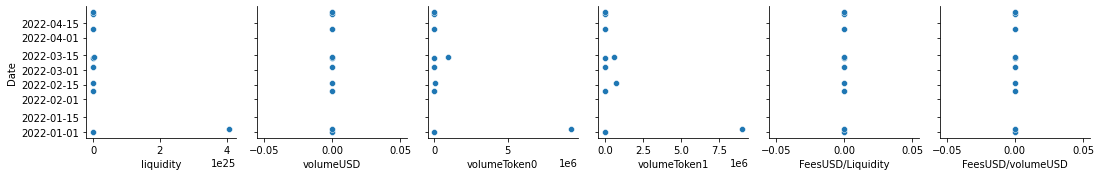

In [28]:
x_vars=['liquidity','volumeUSD','volumeToken0','volumeToken1','FeesUSD/Liquidity','FeesUSD/volumeUSD']
graph = sns.PairGrid(df_req,diag_sharey=False,x_vars=x_vars,y_vars=['Date'])
graph.map_offdiag(sns.scatterplot)